# Generate data samples

## Phase space samples

In [1]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)  # not interested in warnings now

In [2]:
from pycompwa.expertsystem.amplitude.helicitydecay import (
    HelicityAmplitudeGeneratorXML,
)
from pycompwa.expertsystem.ui.system_control import (
    InteractionTypes,
    StateTransitionManager,
)

initial_state = [("J/psi", [-1, 1])]
final_state = [("gamma"), ("pi0"), ("pi0")]
tbd_manager = StateTransitionManager(
    initial_state,
    final_state,
    formalism_type="helicity",
    topology_building="isobar",
)

tbd_manager.set_allowed_interaction_types(
    [InteractionTypes.Strong, InteractionTypes.EM]
)
tbd_manager.allowed_intermediate_particles = ["f"]

graph_interaction_settings_groups = tbd_manager.prepare_graphs()
solutions, _ = tbd_manager.find_solutions(graph_interaction_settings_groups)

print("found " + str(len(solutions)) + " solutions!")

xml_generator = HelicityAmplitudeGeneratorXML()
xml_generator.generate(solutions)
xml_generator.write_to_file("model.xml")

2021-10-23 11:17:07,461 INFO [default] Logging to file disabled!
2021-10-23 11:17:07,461 [INFO] Log level: INFO
2021-10-23 11:17:07,461 [INFO] Current date and time: Sat Oct 23 11:17:07 2021



/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/traitlets/traitlets.py:3050: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,


found 32 solutions!


Now we can go through the procedure explained above:

In [3]:
import pycompwa.ui as pwa

In [4]:
# specify kinematics
kinematics = pwa.create_helicity_kinematics("model.xml")

# specify generators
generator = pwa.EvtGenGenerator(
    kinematics.get_particle_state_transition_kinematics_info()
)
random_generator = pwa.StdUniformRealGenerator(12345)

# generate phase space sample
phsp_sample = pwa.generate_phsp(1000, generator, random_generator)

2021-10-23 11:17:12,854 [INFO] HelicityKinematics::HelicityKinematics() | Initialized kinematics for reaction ( J/psi )->( gamma[ID=2] pi0[ID=3] pi0[ID=4] )
Event position to final state ID mapping:
0: 2
1: 3
2: 4



2021-10-23 11:17:12,856 [INFO] Generating phase-space MC: [1000 events] 


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               

 0.00min [ ********** 100.00% ] 0.00min , end time: 11:17AM               

## Intensity-based samples

In [5]:
# create intensity profile
particle_list = pwa.read_particles("model.xml")
intensity_builder = pwa.IntensityBuilderXML(
    "model.xml", particle_list, kinematics, phsp_sample
)
intensity = intensity_builder.create_intensity()

# generate data
data_sample = pwa.generate(
    100, kinematics, generator, intensity, random_generator
)

2021-10-23 11:17:12,877 [INFO] Setting phase space sample weights...


2021-10-23 11:17:12,884 [INFO] Updating data container content...


2021-10-23 11:17:12,905 [INFO] Generating hit-and-miss sample: [100 events] 


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               


 0.02min [ ********** 100.00% ] 0.00min , end time: 11:17AM               2021-10-23 11:17:13,163 [INFO] Successfully generated 100 with an efficiency of 0.00666667


## Importance sampling

In the example above, we used the decay $J/\psi \to \gamma \pi^0 \pi^0$ with
f resonances only. Imagine, however, that we want to investigate the
resonance $\omega \to \gamma\pi^0$. This resonance has such a narrow peak
that you will run into problems when normalizing the intensity model.

To normalize a distribution, you need know the integral over that
distribution. The integral over an intensity distribution distribution can
only be computed numerically. We simply do this by computing the sum of the
intensities evaluated for each point in a phase space (Monte Carlo
integration), and averaging over the number of phase space points. This means
that the higher the number of phase space points, the more accurate your
integral.

With a narrow peak, however, many of the points in an evenly distributed
phase space sample will lie outside the peak region, where the intensity (and
therefore their contribution to the integral) is highest. So in order to have
a good estimate for the integral over this narrow peak structure, you want to
have a larger number of phase space points under that peak. Now, you could
just use a bigger phase space sample (increasing number of points within the
peak region), but this will be resource intensive as it will result in many
hits in regions that hardly contributes to the integral.

A smarter strategy is generate a sample that has a higher density of phase
space points within the peak region. This strategy is called **importance
sampling**.

In [6]:
from pycompwa.expertsystem.amplitude.helicitydecay import (
    HelicityAmplitudeGeneratorXML,
)
from pycompwa.expertsystem.state.particle import particle_list
from pycompwa.expertsystem.ui.system_control import (
    InteractionTypes,
    StateTransitionManager,
)

initial_state = [("J/psi", [-1, 1])]
final_state = [("gamma"), ("pi0"), ("pi0")]
tbd_manager = StateTransitionManager(
    initial_state,
    final_state,
    formalism_type="helicity",
    topology_building="isobar",
)

# Widen omega resonance
omega = particle_list["omega(782)"]
parameters = omega["DecayInfo"]["Parameter"]
for par in parameters:
    if par["@Type"] == "Width":
        par["Value"] = 0.001

tbd_manager.set_allowed_interaction_types(
    [InteractionTypes.Strong, InteractionTypes.EM]
)
tbd_manager.allowed_intermediate_particles = ["f2(1270)", "omega"]
graph_interaction_settings_groups = tbd_manager.prepare_graphs()
solutions, _ = tbd_manager.find_solutions(graph_interaction_settings_groups)

print("found " + str(len(solutions)) + " solutions!")

xml_generator = HelicityAmplitudeGeneratorXML()
xml_generator.generate(solutions)
xml_generator.write_to_file("model.xml")

found 28 solutions!


In [7]:
import pycompwa.ui as pwa

In [8]:
# specify kinematics
particle_list = pwa.read_particles("model.xml")
kinematics = pwa.create_helicity_kinematics("model.xml", particle_list)

# specify generators
generator = pwa.EvtGenGenerator(
    kinematics.get_particle_state_transition_kinematics_info()
)
random_generator = pwa.StdUniformRealGenerator(12345)

# generate evenly distributed phase space sample
phsp_sample = pwa.generate_phsp(100000, generator, random_generator)

# create intensity
intensity_builder = pwa.IntensityBuilderXML(
    "model.xml", particle_list, kinematics, phsp_sample
)
intensity = intensity_builder.create_intensity()

# generate importance-sampled phase space sample
phsp_sample_importance = pwa.generate_importance_sampled_phsp(
    2000, kinematics, generator, intensity, random_generator
)

2021-10-23 11:17:15,797 [INFO] HelicityKinematics::HelicityKinematics() | Initialized kinematics for reaction ( J/psi )->( gamma[ID=2] pi0[ID=3] pi0[ID=4] )
Event position to final state ID mapping:
0: 2
1: 3
2: 4



2021-10-23 11:17:15,798 [INFO] Generating phase-space MC: [100000 events] 


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               


 0.00min [ ********** 100.00% ] 0.00min , end time: 11:17AM               


2021-10-23 11:17:15,886 [INFO] Setting phase space sample weights...


2021-10-23 11:17:15,888 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_1+pi0_0; already exists!


2021-10-23 11:17:15,889 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_1+pi0_0; already exists!


2021-10-23 11:17:15,890 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_-1+pi0_0; already exists!


2021-10-23 11:17:15,891 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_-1+pi0_0; already exists!


2021-10-23 11:17:15,892 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_1+pi0_0; already exists!


2021-10-23 11:17:15,893 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_1+pi0_0; already exists!


2021-10-23 11:17:15,894 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_-1+pi0_0; already exists!


2021-10-23 11:17:15,894 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_-1+pi0_0; already exists!


2021-10-23 11:17:15,899 [INFO] Updating data container content...


2021-10-23 11:17:17,857 [INFO] Generating phase space sample (hit-and-miss importance sampled): [2000 events] 


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               


2021-10-23 11:17:18,267 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 46.4232 value and restart generation!


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               


2021-10-23 11:17:18,470 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 51.6626 value and restart generation!


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               

2021-10-23 11:17:18,879 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 69.7599 value and restart generation!


 0.05min [ ********** 100.00% ] 0.00min , end time: 11:17AM               


The effect of this importance sampling can be best seen in a Dalitz plot.
There, one can see that there are more events in the regions where the
intensity is large (the resonances), but one still sees a uniform
distribution overall.

In [9]:
kinematics.create_all_subsystems()
phsp_set = kinematics.convert(phsp_sample)
phsp_set_importance = kinematics.convert(phsp_sample_importance)

2021-10-23 11:17:21,823 [INFO] creating all Subsystems!


In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pycompwa.data import naming

In [11]:
def dalitz_plot(data_set, mass_x, mass_y, bins=50, **kwargs):
    """Helper function to create a Dalitz plot with useful axis titles."""
    plt.hist2d(
        data_set.data[mass_x],
        data_set.data[mass_y],
        weights=data_set.weights,
        bins=bins,
        **kwargs,
    )
    plt.xlabel(naming.replace_ids(mass_x, kinematics))
    plt.ylabel(naming.replace_ids(mass_y, kinematics))

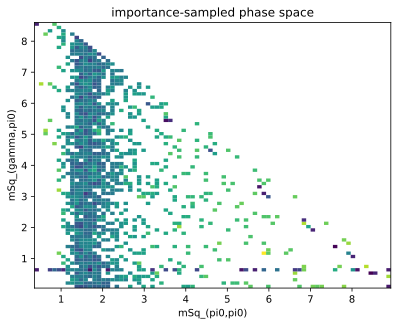

In [12]:
dalitz_plot(
    phsp_set_importance, "mSq_(3,4)", "mSq_(2,4)", bins=80, norm=LogNorm()
)
plt.gca().set_title("importance-sampled phase space");

Note how this compares to the evenly distributed phase space sample and the
intensity-based sample:

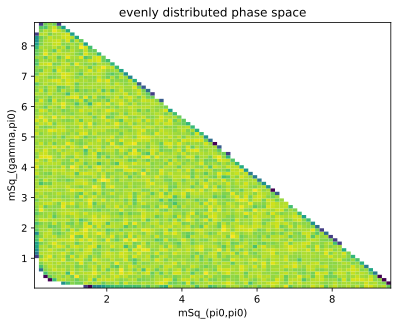

In [13]:
dalitz_plot(phsp_set, "mSq_(3,4)", "mSq_(2,4)", bins=80, norm=LogNorm())
plt.gca().set_title("evenly distributed phase space");

2021-10-23 11:17:25,220 [INFO] Logging to file disabled!


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               


 0.00min [ ---------- 0.00% ] 0.00min , end time: 11:17AM               

 0.05min [ ********** 100.00% ] 0.00min , end time: 11:17AM               

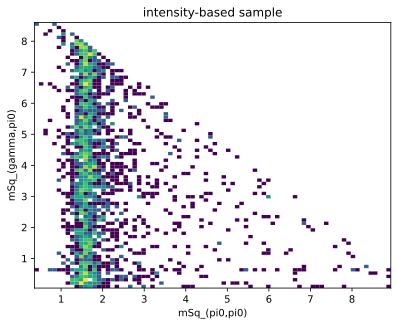

In [14]:
pwa.Logging("error")
data_sample = pwa.generate(
    2000, kinematics, generator, intensity, random_generator
)
data_set = kinematics.convert(data_sample)
dalitz_plot(data_set, "mSq_(3,4)", "mSq_(2,4)", bins=80, norm=LogNorm())
plt.gca().set_title("intensity-based sample");